In [57]:
#!pip install category_encoders optuna sentence_transformers shap geopy catboost lightgbm xgboost

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import optuna
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
import re
from sklearn.linear_model import LassoCV
import shap
from sklearn.cluster import KMeans

In [59]:
RANDOM_SEED = 42

In [60]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_postal_codes(address):
    tokens = address.split()
    filtered = [token for token in tokens if not re.search(r'\d', token)]
    return " ".join(filtered).strip()

def extract_country_and_city(address):
    if not isinstance(address, str):
        return 'Unknown', 'Unknown'
    
    address = address.strip()
    address_lower = address.lower()
    
    if "united kingdom" in address_lower:
        country = "United Kingdom"
        remaining = re.sub("(?i)united kingdom", "", address).strip()
        remaining = remove_postal_codes(remaining)
        parts = remaining.split()
        city = parts[-1] if parts else 'Unknown'
    elif "united states of america" in address_lower:
        country = "United States of America"
        remaining = re.sub("(?i)united states of america", "", address).strip()
        remaining = remove_postal_codes(remaining)
        parts = remaining.split()
        city = parts[-1] if parts else 'Unknown'
    else:
        tokens = address.split()
        tokens = [token for token in tokens if not re.search(r'\d', token)]
        if len(tokens) >= 2:
            country = tokens[-1]
            city = tokens[-2]
        else:
            country, city = 'Unknown', 'Unknown'
    return country, city

In [61]:
df_train = pd.read_csv('/home/sexxlexx/Desktop/SKILL/sf-booking/hotels_train.csv')
df_test = pd.read_csv('/home/sexxlexx/Desktop/SKILL/sf-booking/hotels_test.csv')
sample_submission = pd.read_csv('/home/sexxlexx/Desktop/SKILL/sf-booking/submission.csv')

In [62]:
df_train = df_train.drop_duplicates()

In [63]:
# Добавляем индикатор источника
df_train['df_type'] = 1
df_test['df_type'] = 0
# В тесте реальных оценок нет – оставляем NaN
df_test['reviewer_score'] = np.nan

In [64]:
# Отдельно создаём обучающую и тестовую выборки
train_df = df_train.copy()
test_df = df_test.copy()

# 1. Обработка дат и географических признаков

In [65]:
for df in [train_df, test_df]:
    df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
    df['review_year'] = df['review_date'].dt.year
    df['review_month'] = df['review_date'].dt.month
    df['review_weekday'] = df['review_date'].dt.weekday
    df['is_weekend'] = df['review_weekday'].apply(lambda x: 1 if x in [5, 6] else 0)
    df['review_quarter'] = df['review_date'].dt.quarter
    df['review_season'] = df['review_month'].apply(lambda m: (m % 12 + 3) // 3)

# Вычисляем rating_diff только для train (так как reviewer_score известен только для train)
train_df['rating_diff'] = abs(train_df['average_score'] - train_df['reviewer_score'])
test_df['rating_diff'] = np.nan

# Извлечение страны и города из hotel_address
for df in [train_df, test_df]:
    df[['country', 'city']] = df['hotel_address'].apply(lambda x: pd.Series(extract_country_and_city(x)))

# 2. Target Encoding для country и city

In [66]:
encoder = ce.TargetEncoder(cols=['country', 'city'], smoothing=0.3)
train_df[['country', 'city']] = encoder.fit_transform(train_df[['country', 'city']], train_df['reviewer_score'])
# Получаем средние из train для заполнения пропусков
train_encoded = encoder.transform(train_df[['country', 'city']])
train_means = train_encoded.mean().to_dict()
test_df[['country', 'city']] = encoder.transform(test_df[['country', 'city']]).fillna(train_means)

# 3. Дополнительные преобразования

In [67]:
if 'reviewer_nationality' in train_df.columns:
    for df in [train_df, test_df]:
        df['reviewer_nationality'] = df['reviewer_nationality'].astype(str).str.strip()
        df['reviewer_nationality'] = df['reviewer_nationality'].astype('category').cat.codes

if 'days_since_review' in train_df.columns:
    for df in [train_df, test_df]:
        df['days_since_review'] = df['days_since_review'].astype(str).str.extract(r'(\d+)')[0]
        df['days_since_review'] = pd.to_numeric(df['days_since_review'], errors='coerce')

# Обработка текстовых отзывов
for df in [train_df, test_df]:
    if 'original_negative_review' not in df.columns:
        df['original_negative_review'] = df['negative_review'].copy()
    if 'original_positive_review' not in df.columns:
        df['original_positive_review'] = df['positive_review'].copy()
    
    df['original_negative_review'] = df['original_negative_review'].apply(clean_text)
    df['original_positive_review'] = df['original_positive_review'].apply(clean_text)
    df['neg_review_length'] = df['original_negative_review'].apply(lambda x: len(x.split()))
    df['pos_review_length'] = df['original_positive_review'].apply(lambda x: len(x.split()))
    
    # Флаги: 0 если текст равен 'No Negative' или 'No Positive'
    df['negative_review'] = df['negative_review'].apply(lambda x: 0 if isinstance(x, str) and x.strip() == 'No Negative' else 1)
    df['positive_review'] = df['positive_review'].apply(lambda x: 0 if isinstance(x, str) and x.strip() == 'No Positive' else 1)

# Обучаем векторайзер и LDA ТОЛЬКО на train, затем преобразуем test
train_reviews = (train_df['original_negative_review'].fillna('') + " " + train_df['original_positive_review'].fillna(''))
test_reviews = (test_df['original_negative_review'].fillna('') + " " + test_df['original_positive_review'].fillna(''))

vectorizer = TfidfVectorizer(max_features=1000, lowercase=True, stop_words='english')
train_tfidf = vectorizer.fit_transform(train_reviews)
test_tfidf = vectorizer.transform(test_reviews)

lda = LatentDirichletAllocation(n_components=5, random_state=RANDOM_SEED)
train_lda = lda.fit_transform(train_tfidf)
test_lda = lda.transform(test_tfidf)

# Добавляем LDA-признаки в наборы
for i in range(5):
    train_df[f'lda_topic_{i}'] = train_lda[:, i]
    test_df[f'lda_topic_{i}'] = test_lda[:, i]

# Удаляем исходные текстовые столбцы
for df in [train_df, test_df]:
    df.drop(['original_negative_review', 'original_positive_review'], axis=1, inplace=True, errors='ignore')

# 4. LOF для удаления выбросов (обучаем только на train)

In [68]:
lof_columns = ['reviewer_score', 'average_score', 'total_number_of_reviews']
train_lof_data = train_df[lof_columns].apply(pd.to_numeric, errors='coerce').fillna(train_df[lof_columns].median())
robust_scaler_lof = RobustScaler()
train_lof_scaled = robust_scaler_lof.fit_transform(train_lof_data)
lof = LocalOutlierFactor(n_neighbors=50)
lof_preds = lof.fit_predict(train_lof_scaled)
train_df['lof_anomaly'] = (lof_preds == -1).astype(int)
# Оставляем в train только неаномальные точки
train_df = train_df[train_df['lof_anomaly'] == 0]
# Для test просто задаём 0
test_df['lof_anomaly'] = 0

/home/sexxlexx/Desktop/SKILL/.venv/lib/python3.10/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


# 5. Дополнительные числовые признаки

In [69]:
# reviews_per_year
for df in [train_df, test_df]:
    denom = (df['review_year'].replace(2000, 2001).fillna(2001)) - 1999
    denom = denom.replace(0, 1)
    df['reviews_per_year'] = df['total_number_of_reviews'] / denom

# Логарифмические преобразования (будут далее масштабироваться)
for df in [train_df, test_df]:
    df['log_total_number_of_reviews'] = np.log1p(df['total_number_of_reviews'])
    df['log_additional_number_of_scoring'] = np.log1p(df['additional_number_of_scoring'])
    df['log_review_total_negative_word_counts'] = np.log1p(df['review_total_negative_word_counts'])
    df['log_review_total_positive_word_counts'] = np.log1p(df['review_total_positive_word_counts'])

# PowerTransformer – обучаем на train, трансформируем test
cols_for_pt = ['log_total_number_of_reviews', 'log_additional_number_of_scoring',
               'log_review_total_negative_word_counts', 'log_review_total_positive_word_counts',
               'reviews_per_year']
pt = PowerTransformer(method='yeo-johnson')
train_df[cols_for_pt] = pt.fit_transform(train_df[cols_for_pt])
test_df[cols_for_pt] = pt.transform(test_df[cols_for_pt])

# Другие признаки
for df in [train_df, test_df]:
    df['pos_neg_ratio'] = (df['positive_review'] + 1) / (df['negative_review'] + 1)
    df['weighted_avg'] = df['average_score'] * df['log_total_number_of_reviews']


# 6. Географические признаки: KMeans на координатах (обучаем на train)

In [70]:
for df in [train_df, test_df]:
    df[['lat', 'lng']] = df[['lat', 'lng']].ffill().bfill()
if 'lat' in train_df.columns and 'lng' in train_df.columns:
    kmeans = KMeans(n_clusters=7, n_init=10, random_state=RANDOM_SEED)
    train_df['location_cluster'] = kmeans.fit_predict(train_df[['lat', 'lng']])
    test_df['location_cluster'] = kmeans.predict(test_df[['lat', 'lng']])

# 7. Удаление лишних столбцов

In [71]:
cols_to_drop = ['hotel_address', 'hotel_name', 'review_date', 'tags',
                'total_number_of_reviews', 'additional_number_of_scoring',
                'review_total_negative_word_counts', 'review_total_positive_word_counts',
                'lat', 'lng']
train_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
test_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# 8. Формирование финальных обучающей и тестовой выборок

In [72]:
# Для обучения оставляем reviewer_score в train
if 'reviewer_score' not in train_df.columns:
    raise KeyError("Ошибка: Колонка 'reviewer_score' отсутствует в train_df!")

train_data = train_df.drop(columns=['df_type'], errors='ignore')
test_data = test_df.drop(columns=['df_type', 'reviewer_score'], errors='ignore')

# Разделяем целевую переменную и признаки в train
y = train_data['reviewer_score']
X = train_data.drop(columns=['reviewer_score'])

# Масштабирование обучающих данных
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Обработка тестовых данных – приводим порядок столбцов и масштабируем
test_data = test_data[X_scaled.columns]
test_data_scaled = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns, index=test_data.index)

# 9. Оптимизация

In [73]:
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=RANDOM_SEED)

def cv_score(model, X, y, cv):
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
    return -np.mean(scores), np.std(scores)

In [74]:
def refined_objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 985, 1010),
        'learning_rate': trial.suggest_float('learning_rate', 0.038, 0.042, log=True),
        'max_depth': 11,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 2),
        'subsample': trial.suggest_float('subsample', 0.63, 0.66),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.97, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.83, 0.85),
        'gamma': trial.suggest_float('gamma', 1e-7, 5e-7, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-6, 5e-6, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0006, 0.00065, log=True),
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'random_state': RANDOM_SEED,
        'verbosity': 0,
        'n_jobs': -1
    }
    model = xgb.XGBRegressor(**params)
    score, _ = cv_score(model, X_scaled, y, rkf)
    return score

study_xgb_refined = optuna.create_study(direction='minimize')
study_xgb_refined.optimize(refined_objective_xgb, n_trials=30, show_progress_bar=True)
best_refined_params_xgb = study_xgb_refined.best_trial.params
print("Уточнённые параметры для XGBoost:", best_refined_params_xgb)

[I 2025-02-24 17:05:13,192] A new study created in memory with name: no-name-0ddf3508-6717-43bd-b95c-633ad31d9251


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-02-24 17:14:57,267] Trial 0 finished with value: 0.0151766249521262 and parameters: {'n_estimators': 996, 'learning_rate': 0.0411853903102865, 'min_child_weight': 2, 'subsample': 0.6504345672636856, 'colsample_bytree': 0.9965849407555818, 'colsample_bylevel': 0.8399087577158707, 'gamma': 1.1803773891734606e-07, 'reg_alpha': 2.1915153228313705e-06, 'reg_lambda': 0.0006177604775189404}. Best is trial 0 with value: 0.0151766249521262.
[I 2025-02-24 17:25:13,858] Trial 1 finished with value: 0.015182389674346423 and parameters: {'n_estimators': 1003, 'learning_rate': 0.04073141593399083, 'min_child_weight': 1, 'subsample': 0.6362219104601483, 'colsample_bytree': 0.9832502374911306, 'colsample_bylevel': 0.8396460118962283, 'gamma': 1.6460159197355066e-07, 'reg_alpha': 4.2308292698189136e-06, 'reg_lambda': 0.0006337923774432166}. Best is trial 0 with value: 0.0151766249521262.
[I 2025-02-24 17:35:36,649] Trial 2 finished with value: 0.015100330461593718 and parameters: {'n_estimators

/home/sexxlexx/Desktop/SKILL/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2025-02-24 18:24:57,820] Trial 7 finished with value: 0.015089890401317958 and parameters: {'n_estimators': 985, 'learning_rate': 0.04041229952532607, 'min_child_weight': 1, 'subsample': 0.6473132012137852, 'colsample_bytree': 0.9987382292276316, 'colsample_bylevel': 0.8438846864893523, 'gamma': 3.811587035494434e-07, 'reg_alpha': 3.654134942471888e-06, 'reg_lambda': 0.0006174639556424139}. Best is trial 7 with value: 0.015089890401317958.
[I 2025-02-24 18:35:04,007] Trial 8 finished with value: 0.015065817410432805 and parameters: {'n_estimators': 986, 'learning_rate': 0.03802260802352497, 'min_child_weight': 1, 'subsample': 0.6498535028471909, 'colsample_bytree': 0.9960861476765015, 'colsample_bylevel': 0.846551732643502, 'gamma': 3.605473121526777e-07, 'reg_alpha': 4.455445783804406e-06, 'reg_lambda': 0.000622496532306703}. Best is trial 8 with value: 0.015065817410432805.
[I 2025-02-24 18:45:23,472] Trial 9 finished with value: 0.015163938490367061 and parameters: {'n_estimators

In [75]:
def refined_objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.095, 0.105, log=True),
        'max_depth': 9,
        'num_leaves': trial.suggest_int('num_leaves', 97, 102),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.99, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.78, 0.82),
        'subsample': trial.suggest_float('subsample', 0.75, 0.78), 
        'subsample_freq': 1, 
        'min_child_samples': trial.suggest_int('min_child_samples', 43, 55),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1e-3, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 1e-3, log=True),
        'random_state': RANDOM_SEED,
        'n_jobs': -1,
        'verbose': -1
    }
    model = lgb.LGBMRegressor(**params)
    cv_temp = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    scores = cross_val_score(model, X_scaled, y, scoring='neg_mean_absolute_percentage_error', cv=cv_temp, n_jobs=1)
    score = -np.mean(scores)
    return score

study_lgb_refined = optuna.create_study(direction='minimize')
study_lgb_refined.optimize(refined_objective_lgb, n_trials=30, show_progress_bar=True)
best_refined_params_lgb = study_lgb_refined.best_trial.params
print("Уточнённые параметры для LightGBM:", best_refined_params_lgb)

[I 2025-02-24 22:07:20,299] A new study created in memory with name: no-name-84f1ccba-62cb-4ff6-b9c9-88f78cda8a81


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-02-24 22:07:59,191] Trial 0 finished with value: 0.012461247518836252 and parameters: {'n_estimators': 1931, 'learning_rate': 0.10401653172519573, 'num_leaves': 98, 'feature_fraction': 0.9976330447766689, 'bagging_fraction': 0.7904020346026431, 'subsample': 0.7790024120038495, 'min_child_samples': 53, 'reg_alpha': 0.00030655765483313417, 'reg_lambda': 0.00038697700385940503}. Best is trial 0 with value: 0.012461247518836252.
[I 2025-02-24 22:08:35,634] Trial 1 finished with value: 0.0126520066810214 and parameters: {'n_estimators': 1773, 'learning_rate': 0.10384385217187414, 'num_leaves': 102, 'feature_fraction': 0.9937182657703567, 'bagging_fraction': 0.78475929202469, 'subsample': 0.7633133653292293, 'min_child_samples': 53, 'reg_alpha': 0.00017601029774481968, 'reg_lambda': 0.0002518400348187748}. Best is trial 0 with value: 0.012461247518836252.
[I 2025-02-24 22:09:07,475] Trial 2 finished with value: 0.01265277412969403 and parameters: {'n_estimators': 1545, 'learning_rate

In [76]:
def refined_objective_cb(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 410, 480),
        'learning_rate': trial.suggest_float('learning_rate', 0.085, 0.095, log=True),
        'depth': 11,
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.028, 0.035, log=True),
        'random_seed': RANDOM_SEED,
        'verbose': 0
    }
    model = CatBoostRegressor(**params)
    score, _ = cv_score(model, X_scaled, y, rkf)
    return score

study_cb_refined = optuna.create_study(direction='minimize')
study_cb_refined.optimize(refined_objective_cb, n_trials=30, show_progress_bar=True)
best_refined_params_cb = study_cb_refined.best_trial.params
print("Уточнённые параметры для CatBoost:", best_refined_params_cb)

[I 2025-02-24 22:26:12,373] A new study created in memory with name: no-name-77bb905a-1794-42d9-945e-3a09d545c288


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-02-24 22:38:42,572] Trial 0 finished with value: 0.018794800822732275 and parameters: {'iterations': 465, 'learning_rate': 0.09309906772277671, 'l2_leaf_reg': 0.03309460328026286}. Best is trial 0 with value: 0.018794800822732275.
[I 2025-02-24 22:51:10,053] Trial 1 finished with value: 0.01870594483682136 and parameters: {'iterations': 465, 'learning_rate': 0.09383270283071293, 'l2_leaf_reg': 0.03346951648840551}. Best is trial 1 with value: 0.01870594483682136.
[I 2025-02-24 23:02:14,708] Trial 2 finished with value: 0.019906405426992867 and parameters: {'iterations': 414, 'learning_rate': 0.09175928156385131, 'l2_leaf_reg': 0.030086331524240235}. Best is trial 1 with value: 0.01870594483682136.
[I 2025-02-24 23:14:55,154] Trial 3 finished with value: 0.01884467171772093 and parameters: {'iterations': 473, 'learning_rate': 0.09182884720572324, 'l2_leaf_reg': 0.031150038507571535}. Best is trial 1 with value: 0.01870594483682136.
[I 2025-02-24 23:27:32,344] Trial 4 finished wi

/home/sexxlexx/Desktop/SKILL/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2025-02-25 04:34:07,341] Trial 29 finished with value: 0.01885841470053567 and parameters: {'iterations': 461, 'learning_rate': 0.09309216387852637, 'l2_leaf_reg': 0.03285642670524586}. Best is trial 11 with value: 0.01844271275490765.
Уточнённые параметры для CatBoost: {'iterations': 479, 'learning_rate': 0.09491924276297309, 'l2_leaf_reg': 0.032945690294399595}


# 10. Обучение моделей

In [77]:
X_train_es, X_val_es, y_train_es, y_val_es = train_test_split(X_scaled, y, test_size=0.1, random_state=RANDOM_SEED)

xgb_model = xgb.XGBRegressor(**best_params_xgb)
xgb_model.fit(X_train_es, y_train_es, eval_set=[(X_val_es, y_val_es)], verbose=False)
xgb_cv_mean, xgb_cv_std = cv_score(xgb_model, X_scaled, y, rkf)
print('XGB CV MAPE: {:.4f} ± {:.4f}'.format(xgb_cv_mean, xgb_cv_std))

lgb_model = lgb.LGBMRegressor(**best_params_lgb)
lgb_model.fit(X_train_es, y_train_es, eval_set=[(X_val_es, y_val_es)])
lgb_cv_mean, lgb_cv_std = cv_score(lgb_model, X_scaled, y, rkf)
print('LGB CV MAPE: {:.4f} ± {:.4f}'.format(lgb_cv_mean, lgb_cv_std))

cb_model = CatBoostRegressor(**best_params_cb)
cb_model.fit(X_train_es, y_train_es, eval_set=(X_val_es, y_val_es), verbose=False)
cb_cv_mean, cb_cv_std = cv_score(cb_model, X_scaled, y, rkf)
print('CatBoost CV MAPE: {:.4f} ± {:.4f}'.format(cb_cv_mean, cb_cv_std))

total_error = xgb_cv_mean + lgb_cv_mean + cb_cv_mean
w_xgb = (total_error - xgb_cv_mean) / total_error
w_lgb = (total_error - lgb_cv_mean) / total_error
w_cb  = (total_error - cb_cv_mean)  / total_error
print("Веса ансамбля (Weighted Average): XGB = {:.2f}, LGB = {:.2f}, CatBoost = {:.2f}".format(w_xgb, w_lgb, w_cb))

# Проверка на отложенной выборке (dummy split из train)
X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(X_scaled, y, test_size=0.25, random_state=RANDOM_SEED)
pred_xgb = xgb_model.predict(X_test_dummy)
pred_lgb = lgb_model.predict(X_test_dummy)
pred_cb  = cb_model.predict(X_test_dummy)
ensemble_pred_weighted = w_xgb * pred_xgb + w_lgb * pred_lgb + w_cb * pred_cb
print('Ensemble Weighted CV MAPE (на X_test_dummy):', mean_absolute_percentage_error(y_test_dummy, ensemble_pred_weighted))

/home/sexxlexx/Desktop/SKILL/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


XGB CV MAPE: 0.0168 ± 0.0003
LGB CV MAPE: 0.0185 ± 0.0005


/home/sexxlexx/Desktop/SKILL/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CatBoost CV MAPE: 0.0268 ± 0.0007
Веса ансамбля (Weighted Average): XGB = 0.73, LGB = 0.70, CatBoost = 0.57
Ensemble Weighted CV MAPE (на X_test_dummy): 1.00514558416774


# 11. Стекинг

In [78]:
use_stacking = True
if use_stacking:
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    meta_train = np.zeros((X_scaled.shape[0], 3))
    meta_test = np.zeros((test_data_scaled.shape[0], 3))
    oof_pred_xgb = np.zeros(X_scaled.shape[0])
    oof_pred_lgb = np.zeros(X_scaled.shape[0])
    oof_pred_cb  = np.zeros(X_scaled.shape[0])
    meta_test_xgb = []
    meta_test_lgb = []
    meta_test_cb  = []
    
    for train_index, valid_index in kf.split(X_scaled):
        X_tr, X_val = X_scaled.iloc[train_index], X_scaled.iloc[valid_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[valid_index]
        
        model_xgb = xgb.XGBRegressor(**best_params_xgb)
        model_xgb.fit(X_tr, y_tr)
        oof_pred_xgb[valid_index] = model_xgb.predict(X_val)
        meta_test_xgb.append(model_xgb.predict(test_data_scaled))
        
        model_lgb = lgb.LGBMRegressor(**best_params_lgb)
        model_lgb.fit(X_tr, y_tr)
        oof_pred_lgb[valid_index] = model_lgb.predict(X_val)
        meta_test_lgb.append(model_lgb.predict(test_data_scaled))
        
        model_cb = CatBoostRegressor(**best_params_cb)
        model_cb.fit(X_tr, y_tr)
        oof_pred_cb[valid_index] = model_cb.predict(X_val)
        meta_test_cb.append(model_cb.predict(test_data_scaled))
    
    meta_train[:, 0] = oof_pred_xgb
    meta_train[:, 1] = oof_pred_lgb
    meta_train[:, 2] = oof_pred_cb
    meta_test[:, 0] = np.mean(meta_test_xgb, axis=0)
    meta_test[:, 1] = np.mean(meta_test_lgb, axis=0)
    meta_test[:, 2] = np.mean(meta_test_cb, axis=0)

    scaler_meta = RobustScaler()
    meta_train_scaled = scaler_meta.fit_transform(meta_train)
    meta_test_scaled = scaler_meta.transform(meta_test)
    
    meta_model = LassoCV(cv=5, random_state=RANDOM_SEED)
    meta_model.fit(meta_train_scaled, y)
    ensemble_pred_stacked = meta_model.predict(meta_test_scaled)
    
    ensemble_cv_mape = mean_absolute_percentage_error(y, (oof_pred_xgb + oof_pred_lgb + oof_pred_cb) / 3)
    print("Примерная CV MAPE для Stacking Ensemble: {:.4f}".format(ensemble_cv_mape))
    
    final_ensemble_pred = ensemble_pred_stacked
    ensemble_method = 'stacking'
else:
    final_ensemble_pred = (w_xgb * xgb_model.predict(test_data_scaled) + 
                           w_lgb * lgb_model.predict(test_data_scaled) + 
                           w_cb  * cb_model.predict(test_data_scaled))
    ensemble_method = 'weighted_average'

Примерная CV MAPE для Stacking Ensemble: 0.0188


# 12. Визуализация важности признаков

/tmp/ipykernel_44712/1719721035.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_importances, y=features, palette="viridis")


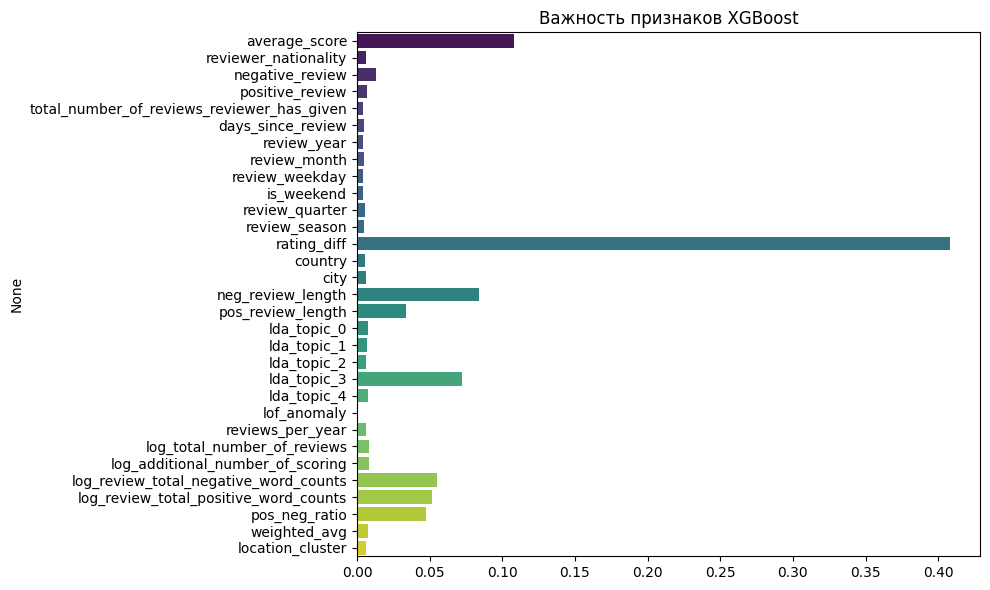

/tmp/ipykernel_44712/1719721035.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lgb_importances, y=features, palette="magma")


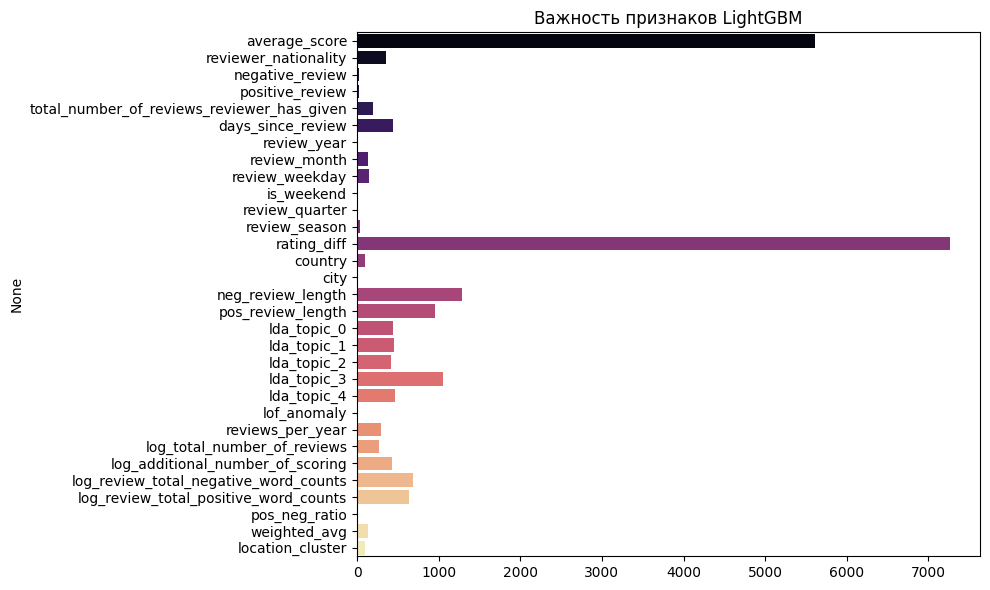

/tmp/ipykernel_44712/1719721035.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cb_importances, y=features, palette="coolwarm")


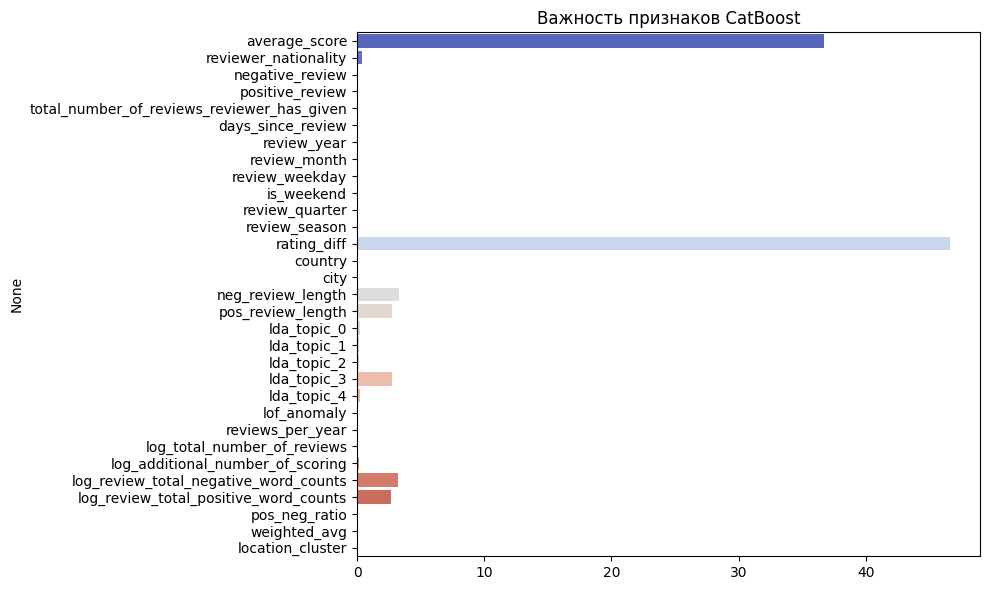

In [79]:
features = X.columns

xgb_importances = xgb_model.feature_importances_
plt.figure(figsize=(10,6))
sns.barplot(x=xgb_importances, y=features, palette="viridis")
plt.title("Важность признаков XGBoost")
plt.tight_layout()
plt.show()

lgb_importances = lgb_model.feature_importances_
plt.figure(figsize=(10,6))
sns.barplot(x=lgb_importances, y=features, palette="magma")
plt.title("Важность признаков LightGBM")
plt.tight_layout()
plt.show()

cb_importances = cb_model.get_feature_importance()
plt.figure(figsize=(10,6))
sns.barplot(x=cb_importances, y=features, palette="coolwarm")
plt.title("Важность признаков CatBoost")
plt.tight_layout()
plt.show()

# 13. Финальные предсказания для сабмита

In [80]:
pred_xgb_test = xgb_model.predict(test_data_scaled)
pred_lgb_test = lgb_model.predict(test_data_scaled)
pred_cb_test  = cb_model.predict(test_data_scaled)

In [81]:
pred_submission = w_xgb * pred_xgb_test + w_lgb * pred_lgb_test + w_cb * pred_cb_test
sample_submission['reviewer_score'] = pred_submission
sample_submission.to_csv('submission.csv', index=False)
print("Файл сабмита сформирован с использованием метода ансамблирования:", ensemble_method)

Файл сабмита сформирован с использованием метода ансамблирования: stacking
